In [40]:
import matplotlib.pyplot as plt
import numpy as np

#superpixels
from sklearn.cluster import MiniBatchKMeans
from skimage.segmentation import slic, mark_boundaries
from skimage import measure
from math import sqrt
import cv2

import skimage.morphology as morphology
from skimage.morphology import opening
import groupXY_functions as util
import random

In [41]:
path = "ISIC_0015243"
random.seed(10)
# load the image and grab its width and height
image = plt.imread(f'data/example_image/{path}.jpg')



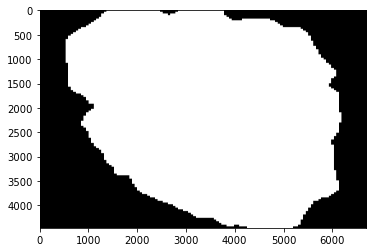

In [42]:
mask = plt.imread(f'data/example_segmentation/{path}_segmentation.png')
plt.imshow(mask, cmap='gray')

In [43]:
image, mask = util.scale_image_res(image, mask)
(h, w) = image.shape[:2]

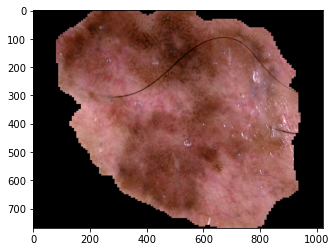

In [44]:
#cut the working space to lesion borders (or smaller). Mask is based on the original image.
#lesion should return the image with reduced colors trimmed by the original mask

#image, _ = util.extract_mask_roi(image, mask, 40, 40)
#image[mask2==0] = 0 #if the mask is black at some spot, set image color to black at that spot
image[mask==0]=0

plt.imshow(image)

In [45]:
# convert the image from the RGB color space to the L*a*b*
# color space -- since we will be clustering using k-means
# which is based on the euclidean distance, we'll use the
# L*a*b* color space where the euclidean distance implies
# perceptual meaning 

#the important thing is this color space is perceptually uniform - the distances between colors are stable, and we can say
#that similar colors always lay within a threshold

image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
image = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)

# reshape the image into a feature vector so that k-means
# can be applied. Basically, we lose the shape of the picture (1 axis of our 3), but preserve color infos
#for K clustering, which works on a 2-dimensional array. Think of scattering the points from their xy coordinates into a random space
image = image.reshape((image.shape[0] * image.shape[1], 3))

# apply k-means using the specified number of clusters (8) and
# then create the quantized image based on the predictions

clt = MiniBatchKMeans(n_clusters = 16, random_state=1)
labels = clt.fit_predict(image)
quant = clt.cluster_centers_.astype("uint8")[labels]

quant

c:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(


array([[  0, 128, 128],
       [  0, 128, 128],
       [  0, 128, 128],
       ...,
       [  0, 128, 128],
       [  0, 128, 128],
       [  0, 128, 128]], dtype=uint8)

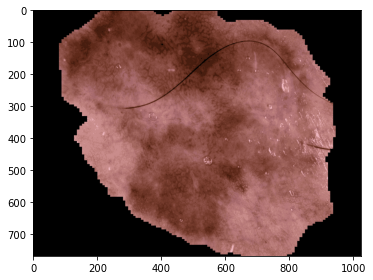

In [46]:

# reshape the feature vectors to images
quant = quant.reshape((h, w, 3))
image = image.reshape((h, w, 3))

# convert from L*a*b* to BGR and then to RGB gor matplotlib plotting
quant = cv2.cvtColor(quant, cv2.COLOR_LAB2BGR)
image = cv2.cvtColor(image, cv2.COLOR_LAB2BGR)

quant = cv2.cvtColor(quant, cv2.COLOR_BGR2RGB)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

#graph = np.hstack([image, quant]) #hstack just makes them appear one after another for comparison
plt.imshow(quant)
plt.tight_layout()

In [47]:
#converting back to LAB color space to measure color variance later uniformly
lesion_ = cv2.cvtColor(quant, cv2.COLOR_RGB2BGR)
lesion_ = cv2.cvtColor(quant, cv2.COLOR_BGR2LAB)

lesion_.shape

(768, 1024, 3)

In [48]:
#losing xy values to focus on colors
colors = lesion_.reshape((lesion_.shape[0] * lesion_.shape[1], 3))

#filtering only to unique colors - this takes most time
colors = np.unique(colors, axis = 0)

colors

array([[  0, 128, 128],
       [ 31, 139, 100],
       [ 47, 142,  94],
       [ 60, 142,  94],
       [ 67, 141,  93],
       [ 77, 141,  93],
       [ 87, 142,  93],
       [ 97, 142,  94],
       [107, 142,  95],
       [116, 140,  95],
       [120, 144,  96],
       [126, 142,  94],
       [134, 144,  95],
       [142, 141,  96],
       [155, 142,  96],
       [196, 142, 102]], dtype=uint8)

In [49]:
#filtering out all black pixels
colors_ = np.delete(colors, np.where(colors <= 2)[0], axis=0) #colors[0] is the luminanace row in LAB

colors_

array([[ 31, 139, 100],
       [ 47, 142,  94],
       [ 60, 142,  94],
       [ 67, 141,  93],
       [ 77, 141,  93],
       [ 87, 142,  93],
       [ 97, 142,  94],
       [107, 142,  95],
       [116, 140,  95],
       [120, 144,  96],
       [126, 142,  94],
       [134, 144,  95],
       [142, 141,  96],
       [155, 142,  96],
       [196, 142, 102]], dtype=uint8)

In [50]:
#CALCULATIONS - the calculations take luminance into consideration

#conversion to a python list
color_variance = colors_.tolist()
max_distance = 0
for i in color_variance:
    for j in color_variance:
        distance = sqrt((i[0]-j[0])**2 + (i[1]-j[1])**2 + (i[2]-j[2])**2)
        print(i,j,distance)
        if distance > max_distance:
            max_distance = distance

print(f'the color variation in the lesion equals {max_distance}')

#considerations
#I need to run some tests to classify if the variance is big small or medium

[31, 139, 100] [31, 139, 100] 0.0
[31, 139, 100] [47, 142, 94] 17.349351572897472
[31, 139, 100] [60, 142, 94] 29.765752132274432
[31, 139, 100] [67, 141, 93] 36.72873534441391
[31, 139, 100] [77, 141, 93] 46.57252408878007
[31, 139, 100] [87, 142, 93] 56.515484603779164
[31, 139, 100] [97, 142, 94] 66.34003316248794
[31, 139, 100] [107, 142, 95] 76.22335600063802
[31, 139, 100] [116, 140, 95] 85.15280382935138
[31, 139, 100] [120, 144, 96] 89.23003978481687
[31, 139, 100] [126, 142, 94] 95.23654760647301
[31, 139, 100] [134, 144, 95] 103.24243313676794
[31, 139, 100] [142, 141, 96] 111.09005356016353
[31, 139, 100] [155, 142, 96] 124.10076550932311
[31, 139, 100] [196, 142, 102] 165.03938923784224
[47, 142, 94] [31, 139, 100] 17.349351572897472
[47, 142, 94] [47, 142, 94] 0.0
[47, 142, 94] [60, 142, 94] 13.0
[47, 142, 94] [67, 141, 93] 20.049937655763422
[47, 142, 94] [77, 141, 93] 30.033314835362415
[47, 142, 94] [87, 142, 93] 40.01249804748511
[47, 142, 94] [97, 142, 94] 50.0
[47, 1

In [51]:
#distance = abs(sqrt(0^2 + (-127)^2 + i[2]^2) - sqrt(j[0]^2 + j[1]^2 + j[2]^2))

#this gives shitty results, it's better to look at each image as it's own, even if it's not 100% uniform.
#we are interested in relative color change anyway

# def universal_conversion(colors): #64 colors, defined in the same way for every picture

#     with np.nditer(colors, op_flags=['readwrite']) as it:
#         for color in it:
#             if color >= 0 and color < 64:
#                 color[...] = 32 #[...] references the array itself, and the values get updated
#             elif color >= 64 and color < 128:
#                 color[...] = 96
#             elif color >= 128 and color < 192:
#                 color[...] = 160
#             else:
#                 color[...] = 224

#     return colors

# print(universal_conversion(size))


In [52]:
#WORKING FUNCTION FOR COPYING


random.seed(10)
# load the image and grab its width and height
image = plt.imread(f'data/example_image/{path}.jpg')

mask = plt.imread(f'data/example_segmentation/{path}_segmentation.png')

image, mask = scale_image_res(image, mask)
(h, w) = image.shape[:2]

#cut the working space to lesion borders (or smaller). Mask is based on the original image.
#lesion should return the image with reduced colors trimmed by the original mask

_, mask2 = extract_mask_roi(image, mask, 20, 20)
image[mask2==0] = 0 #if the mask is black at some spot, set image color to black at that spot

# convert the image from the RGB color space to the L*a*b*
# color space -- since we will be clustering using k-means
# which is based on the euclidean distance, we'll use the
# L*a*b* color space where the euclidean distance implies
# perceptual meaning 

#the important thing is this color space is perceptually uniform - the distances between colors are stable, and we can say
#that similar colors always lay within a threshold

image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
image = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)

# reshape the image into a feature vector so that k-means
# can be applied. Basically, we lose the shape of the picture (1 axis of our 3), but preserve color infos
#for K clustering, which works on a 2-dimensional array. Think of scattering the points from their xy coordinates into a random space
image = image.reshape((image.shape[0] * image.shape[1], 3))

# apply k-means using the specified number of clusters (8) and
# then create the quantized image based on the predictions

clt = MiniBatchKMeans(n_clusters = 8)
labels = clt.fit_predict(image)
quant = clt.cluster_centers_.astype("uint8")[labels]

# reshape the feature vectors to images
quant = quant.reshape((h, w, 3))
image = image.reshape((h, w, 3))

# convert from L*a*b* to BGR and then to RGB gor matplotlib plotting
quant = cv2.cvtColor(quant, cv2.COLOR_LAB2BGR)
image = cv2.cvtColor(image, cv2.COLOR_LAB2BGR)

quant = cv2.cvtColor(quant, cv2.COLOR_BGR2RGB)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

#graph = np.hstack([image, quant]) #hstack just makes them appear one after another for comparison
plt.imshow(quant)
plt.tight_layout()

#converting back to LAB color space to measure color variance later uniformly
lesion_ = cv2.cvtColor(quant, cv2.COLOR_RGB2BGR)
lesion_ = cv2.cvtColor(quant, cv2.COLOR_BGR2LAB)

#losing xy values to focus on colors
colors = lesion_.reshape((lesion_.shape[0] * lesion_.shape[1], 3))

#filtering only to unique colors - this takes most time
colors = np.unique(colors, axis = 0)

#filtering out all black pixels
colors_ = np.delete(colors, np.where(colors <= 2)[0], axis=0) #colors[0] is the luminanace row in LAB

#CALCULATIONS - the calculations take luminance into consideration

#conversion to a python list
color_variance = colors_.tolist()
max_distance = 0
for i in color_variance:
    for j in color_variance:
        distance = sqrt((i[0]-j[0])**2 + (i[1]-j[1])**2 + (i[2]-j[2])**2)
        print(i,j,distance)
        if distance > max_distance:
            max_distance = distance

print(f'the color variation in the lesion equals {max_distance}')

NameError: name 'scale_image_res' is not defined